In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 16, 16, 47, 26, 974355)

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
np.random.shuffle(real_data[1000:])
data = real_data[:1000]
np.random.shuffle(data)

In [7]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [8]:
sample, label = next(iter(train_dataset.take(1)))

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [10]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[ 240 4035 3286   25  194    2 1147  494   15  487  608    4   24   73
    65    4 1468    7   76  413    8    3 4620    6    2 2606  280  898
    91 3197    3  269   26    2   24  380  481    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2  270  356  364  353  760   42    3  726    6 3416  444  102   23
     9  204  464  332    3  479    5 4291   12 4476    4  246    4   32
     5  844  318    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3  753   11 2786   64   16   99 3887    8    3 2031    6    3 3713
  1993  588  281    5    7   24   40    4  100  519    4 1174   13 3318
   993    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


In [12]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'Jack Hall, paleoclimatologist, must make a daring trek from Washington, D.C. to New York City to reach his son, trapped in the cross-hairs of a sudden international storm which plunges the planet into a new Ice Age.'
Round-trip:  jack hall paleoclimatologist must make a daring trek from washington dc to new york city to reach his son trapped in the crosshairs of a sudden international storm which plunges the planet into a new ice age             

Original:  b'A newly recruited night security guard at the Museum of Natural History discovers that an ancient curse causes the animals and exhibits on display to come to life and wreak havoc.'
Round-trip:  a newly recruited night security guard at the museum of natural history discovers that an ancient curse causes the animals and exhibits on display to come to life and wreak havoc                   

Original:  b"The IMF is shut down when it's implicated in the bombing of the Kremlin, causing Ethan Hunt and his new team to go r

In [13]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [14]:
history = model.fit(
    train_dataset, epochs=100
)

Epoch 1/100
14/14 [==============================] - 1s 64ms/step - loss: 36299981254033408.0000
Epoch 2/100
14/14 [==============================] - 1s 62ms/step - loss: 35960805539184640.0000
Epoch 3/100
14/14 [==============================] - 1s 66ms/step - loss: 33946805179777024.0000
Epoch 4/100
14/14 [==============================] - 1s 59ms/step - loss: 27844388944084992.0000
Epoch 5/100
14/14 [==============================] - 1s 57ms/step - loss: 17343214306459648.0000
Epoch 6/100
14/14 [==============================] - 1s 57ms/step - loss: 10389843716603904.0000
Epoch 7/100
14/14 [==============================] - 1s 57ms/step - loss: 10236691625279488.0000
Epoch 8/100
14/14 [==============================] - 1s 59ms/step - loss: 9616560624762880.0000
Epoch 9/100
14/14 [==============================] - 1s 59ms/step - loss: 7984552509177856.0000
Epoch 10/100
14/14 [==============================] - 1s 58ms/step - loss: 6579089959813120.0000
Epoch 11/100
14/14 [============

In [15]:
res = model.evaluate(test_dataset)

3/3 [==============================] - 0s 14ms/step - loss: 30129829089116160.0000


In [16]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

803384320


In [17]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

105748640


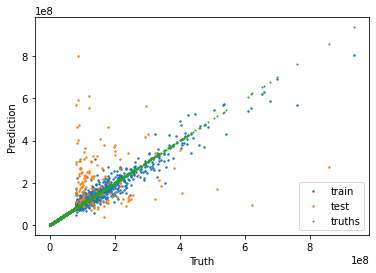

In [18]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

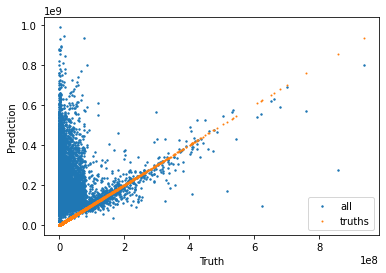

In [21]:
train_predictions = model.predict(train_data_in)
all_predictions = np.array([x for x in real_data if x['synopsis'] not in ])
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(real_data['gross'], all_predictions, label='all', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [22]:
train_data_in[0]

'At a 1962 college, Dean Vernon Wormer is determined to expel the entire Delta Tau Chi Fraternity, but those troublemakers have other plans for him.'